In [47]:
import torch
from torch import nn

import argparse
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm
# Loading relevant libraries and the dataset
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=RuntimeWarning)

from scipy.io import loadmat
import matplotlib
%matplotlib inline

global maximum
maximum={}

minimumAlert=5
showChartBool=True
latex=(not showChartBool)

obsWindows=[32, 64]
slidingValue=16
featuresIndex=None#Used to filter for some features
window=64 #or 32

datasets={
    "train":{
        "normal":"datasets/train/normal.txt"
    },
    "test":{
        "normal":"datasets/test/normal.txt",
        "brute_isolated":"datasets/test/brute_isolated.txt",
        "brute_mixed":"datasets/test/brute_mixed.txt",
        "smooth_isolated":"datasets/test/smooth_isolated.txt",
        "smooth_mixed":"datasets/test/smooth_mixed.txt",
        "intelligent":"datasets/test/intelligent.txt"
    },
    "validation":{
        "normal":"datasets/validation/normal.txt",
        "brute_isolated":"datasets/validation/brute_isolated.txt",
        "brute_mixed":"datasets/validation/brute_mixed.txt",
        "smooth_isolated":"datasets/validation/smooth_isolated.txt",
        "smooth_mixed":"datasets/validation/smooth_mixed.txt",
        "intelligent":"datasets/validation/intelligent.txt"
    }
}

In [48]:
def extractStats(data):
    nSamp,nCols=data.shape

    M1=np.mean(data,axis=0)
    Md1=np.median(data,axis=0)
    Std1=np.std(data,axis=0)
    
    features=np.hstack((M1,Md1,Std1))
    return(features)

def extratctSilenceActivity(data,threshold=0):
    if(data[0]<=threshold):
        s=[1]
        a=[]
    else:
        s=[]
        a=[1]
    for i in range(1,len(data)):
        if(data[i-1]>threshold and data[i]<=threshold):
            s.append(1)
        elif(data[i-1]<=threshold and data[i]>threshold):
            a.append(1)
        elif (data[i-1]<=threshold and data[i]<=threshold):
            s[-1]+=1
        else:
            a[-1]+=1
    return(s,a)
    
def extractStatsSilenceActivity(data):
    features=[]
    nSamples,nMetrics=data.shape
    silence_features=np.array([])
    activity_features=np.array([])
    for c in range(0, nMetrics, 2): #Use only one column from upload and another from download
        silence,activity=extratctSilenceActivity(data[:,c],threshold=0)
        
        if len(silence)>0:
            silence_faux=np.array([len(silence),np.mean(silence),np.std(silence)])
        else:
            silence_faux=np.zeros(3)
        silence_features=np.hstack((silence_features,silence_faux))
        
        if len(activity)>0:
            activity_faux=np.array([len(activity),np.mean(activity),np.std(activity)])
        else:
            activity_faux=np.zeros(3)
        activity_features=np.hstack((activity_features,activity_faux))	   
    features=np.hstack((silence_features,activity_features))
    return(features)

### Function: slidingMultObsWindow
This function returns all the extracted features. The return is a dict containing the windows size (as key) and the list of features extracted from that windows (as value).
Index of the features in the array:
1. Window of 32 seconds:
    1. Mean (4 columns: Upload Size, Upload Count, Download Size, Download Count)
    2. Median (4 columns: Upload Size, Upload Count, Download Size, Download Count)
    3. Standard deviation (4 columns: Up Size, Up Count, Down Size, Down Count)
    4. Silence (6 columns: Mean, Median and Standard deviation for Upload and Download size)
    5. Activity (6 columns: Mean, Median and Standard deviation for Upload and Download size)
1. Window of 64 seconds:
    1. Mean (4 columns: Upload Size, Upload Count, Download Size, Download Count)
    2. Median (4 columns: Upload Size, Upload Count, Download Size, Download Count)
    3. Standard deviation (4 columns: Up Size, Up Count, Down Size, Down Count)
    4. Silence (6 columns: Mean, Median and Standard deviation for Upload and Download size)
    5. Activity (6 columns: Mean, Median and Standard deviation for Upload and Download size)


In [49]:
def slidingMultObsWindow(data,lengthObsWindow,slidingValue, filterIndex=None, defineMax=False):
    nSamples,nMetrics=data.shape
    #Fix windows
    results = {}
    for s in np.arange(max(lengthObsWindow),nSamples,slidingValue):
        features=np.array([])
        for oW in lengthObsWindow:
            if oW not in results:
                results[oW] = []
            subdata=data[s-oW:s,1:]
            faux=extractStats(subdata)
            faux2=extractStatsSilenceActivity(subdata)
            features=np.hstack((features,faux,faux2))
            #print(('{} '*len(features)).format(*features))
            if filterIndex:
                features = features[filterIndex]
            results[oW].append(features)
    
    for oW in lengthObsWindow:
        if oW in results:
            results[oW] = np.array(results[oW])
            global maximum
            if defineMax:
                maximum[oW]=(results[oW].max(axis=0)+np.finfo(np.float32).eps)
            results[oW] = results[oW]/maximum[oW]
            
    return results

In [50]:
def showChart(dataInput):
    if showChartBool:
        name=dataInput.split("/")[1:3]
        print("Traffic from", name[0], "in", name[1], "mode")
        corruptData=np.loadtxt(dataInput,dtype=int)
        plt.figure(figsize=(15,15))
        plt.subplot(2,1,1)
        plt.plot(corruptData[:,0],corruptData[:,1],corruptData[:,0],corruptData[:,3])
        plt.xlabel('Time (seconds)')
        plt.ylabel('Packages count')
        plt.subplot(2,1,2)
        plt.plot(corruptData[:,0],corruptData[:,2],corruptData[:,0],corruptData[:,4])
        plt.xlabel('Time (seconds)')
        plt.ylabel('Packages count')
        plt.show()

In [ ]:
fileInput=datasets["train"]["normal"]
showChart(fileInput)
data=np.loadtxt(fileInput,dtype=int)
normalTraffic = slidingMultObsWindow(data,obsWindows,slidingValue, featuresIndex, True)

In [29]:
traffic={}
for x in datasets:
    traffic[x]={}
    for ds in datasets[x]:
        fin=datasets[x][ds]
        data=np.loadtxt(fin,dtype=int)
        showChart(fin)
        traffic[x][ds] = slidingMultObsWindow(data,obsWindows,slidingValue, featuresIndex)[window]

In [30]:
Xtrain=traffic["train"]["normal"]
torch.manual_seed(111)
train_data_length = len(Xtrain)
train_data = torch.from_numpy(Xtrain)
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]
print(len(train_set))

109


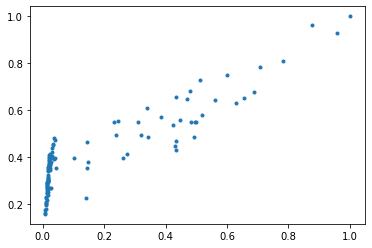

In [31]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [32]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [33]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(48, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [34]:
discriminator = Discriminator()

In [35]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 48),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

In [36]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

In [37]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [38]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        new_batch_size=len(real_samples)
        real_samples_labels = torch.ones((new_batch_size, 1))
        latent_space_samples = torch.randn((new_batch_size, 2))#, dtype=torch.float64)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((new_batch_size, 1))
        
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )
        
        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples.float())
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((new_batch_size,  2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and False:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

In [39]:
#Generate traffic
latent_space_samples = torch.randn(512, 2)
generated_samples = generator(latent_space_samples)
dtset = generated_samples.detach().numpy()

In [40]:
def scores(prediction, botWindow):
    TP=0.00001
    FP=0.00001
    FN=0.00001
    pIndex=0
    for p in prediction:
        if pIndex in botWindow:
            if p == -1:
                TP+=1
            else:
                FN+=1
        else:
            if p == -1:
                FP+=1
            else:
                TP+=1
        pIndex+=1
    try:
        precision=TP/(TP+FP)
        recall=TP/(TP+FN)
        f1=2*((precision*recall)/(precision+recall))
    except:
        return None, None, None
    return precision, recall, f1

def process(dataInput, botWindow, algorithm="svm"):
    data=np.loadtxt(dataInput,dtype=int)
    traffic = slidingMultObsWindow(data,obsWindows,slidingValue, featuresIndex)[window]
    name=dataInput.split("/")[1:3]
    showChart(dataInput)
    
    if algorithm == "svm":
        prediction = clf.predict(traffic)
    elif algorithm == "kmeans":
        prediction=[]
        for obs in traffic:
            dists = euclidean_distances([obs],kmeans.cluster_centers_)
            if dists[0]>maxDst+thresholdKmeans:
                prediction+=[-1]
            else:
                prediction+=[1]
    elif algorithm == "pca_svm":
        pcaFeatures = pca.fit(traffic).transform(traffic)
        prediction = clf.predict(pcaFeatures)

    count=0
    numPositives=0
    pIndex=0
    countAlerts=0
    for value in prediction:
        if value == 1:
            numPositives+=1
            if numPositives >= 2:
                count=0
                numPositives=0
        else:
            count+=1
        if count>=minimumAlert:
            countAlerts+=1
        pIndex+=1
    precision, recall, f1=scores(prediction,botWindow)
    
    if latex:
        print("& &", round(precision, 2), "&", round(recall, 2), "&", round(f1, 2), "&", countAlerts)
    else:  
        print("Traffic from", name[0], "in", name[1], "mode")
        print(prediction)
        print("Scores:")
        print(name[0], "in", name[1], "mode", "Precision:", round(precision, 2), "Recall:", round(recall, 2), "F1-Score:", round(f1, 2), "Alert (%):", countAlerts/(pIndex-minimumAlert+1)*100)
        print("Num Alerts:", countAlerts)
        print("Alert (%):", countAlerts/(pIndex-minimumAlert+1)*100)
        print("\n\n")

## One-Class SVM

In [41]:
train=np.concatenate((Xtrain,dtset), axis=0)
clf = svm.OneClassSVM(nu=0.001, kernel="rbf", gamma='auto')
clf.fit(train)

OneClassSVM(gamma='auto', nu=0.001)

### Validation Data Set

In [42]:
valFiles=[(datasets["validation"]["normal"], [-1]), 
            (datasets["validation"]["brute_isolated"], range(0, 500)), #500, because all traffic contains bot
            (datasets["validation"]["brute_mixed"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
            (datasets["validation"]["smooth_isolated"], range(0, 500)), #500, because all traffic contains bot
            (datasets["validation"]["smooth_mixed"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
            (datasets["validation"]["intelligent"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
           ]
for dataInput, botWin in valFiles:
    process(dataInput, botWin, "svm")

& & 0.85 & 1.0 & 0.92 & 0
& & 1.0 & 1.0 & 1.0 & 11
& & 1.0 & 0.74 & 0.85 & 17
& & 1.0 & 0.67 & 0.8 & 2
& & 1.0 & 0.14 & 0.25 & 0
& & 1.0 & 0.41 & 0.58 & 0


### Test Data Set

In [43]:
testFiles=[(datasets["test"]["normal"], [-1]), 
            (datasets["test"]["brute_isolated"], range(0, 500)), #500, because all traffic contains bot
            (datasets["test"]["brute_mixed"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
            (datasets["test"]["smooth_isolated"], range(0, 500)), #500, because all traffic contains bot
            (datasets["test"]["smooth_mixed"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
            (datasets["test"]["intelligent"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
           ]
for dataInput, botWin in testFiles:
    process(dataInput, botWin, "svm")

& & 0.93 & 1.0 & 0.96 & 0
& & 1.0 & 1.0 & 1.0 & 10
& & 1.0 & 0.2 & 0.33 & 0
& & 1.0 & 0.6 & 0.75 & 4
& & 1.0 & 0.23 & 0.38 & 0
& & 1.0 & 0.21 & 0.35 & 0


## K-Means

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

kmeans = KMeans(n_clusters=1, random_state=0).fit(Xtrain)
print(kmeans.cluster_centers_[0])
#dists = euclidean_distances(kmeans.cluster_centers_)

maxDst=0
for obs in Xtrain:
    dists = euclidean_distances([obs],kmeans.cluster_centers_)
    if dists[0]>maxDst:
        maxDst=dists[0]
thresholdKmeans=maxDst*0.2

[0.17447553 0.4114031  0.47764827 0.5381942  0.10155107 0.41542431
 0.43900036 0.55131881 0.22181069 0.35891877 0.37403391 0.39583336
 0.22542595 0.14278547 0.12984385 0.21756225 0.15305082 0.1367825
 0.28863796 0.30529019 0.34382967 0.28016937 0.31514052 0.33513985
 0.22036476 0.46966913 0.56692548 0.6394573  0.06723988 0.49463442
 0.4497392  0.58794779 0.2882053  0.4857376  0.48604423 0.50711888
 0.35671883 0.33521378 0.25878368 0.34430653 0.34398104 0.27430199
 0.39179708 0.32466331 0.28324961 0.37938478 0.3350758  0.28451993]


### Validation Data Set

In [45]:
valFiles=[(datasets["validation"]["normal"], [-1]), 
            (datasets["validation"]["brute_isolated"], range(0, 500)), #500, because all traffic contains bot
            (datasets["validation"]["brute_mixed"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
            (datasets["validation"]["smooth_isolated"], range(0, 500)), #500, because all traffic contains bot
            (datasets["validation"]["smooth_mixed"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
            (datasets["validation"]["intelligent"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
           ]
for dataInput, botWin in valFiles:
    process(dataInput, botWin, "kmeans")

& & 0.85 & 1.0 & 0.92 & 0
& & 1.0 & 1.0 & 1.0 & 11
& & 1.0 & 0.59 & 0.74 & 13
& & 0.5 & 0.0 & 0.0 & 0
& & 1.0 & 0.11 & 0.19 & 0
& & 1.0 & 0.35 & 0.52 & 0


### Test Data Set

In [46]:
testFiles=[(datasets["test"]["normal"], [-1]), 
            (datasets["test"]["brute_isolated"], range(0, 500)), #500, because all traffic contains bot
            (datasets["test"]["brute_mixed"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
            (datasets["test"]["smooth_isolated"], range(0, 500)), #500, because all traffic contains bot
            (datasets["test"]["smooth_mixed"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
            (datasets["test"]["intelligent"], range(3, 500)), #First minute does not contain bot, so due to the sliding scale, the bot is considered after 3 windows
           ]
for dataInput, botWin in testFiles:
    process(dataInput, botWin, "kmeans")

& & 1.0 & 1.0 & 1.0 & 0
& & 1.0 & 1.0 & 1.0 & 10
& & 1.0 & 0.2 & 0.33 & 0
& & 0.5 & 0.0 & 0.0 & 0
& & 1.0 & 0.23 & 0.38 & 0
& & 1.0 & 0.21 & 0.35 & 0
